# <u>*Multiple Linear Regression*<u>

For this code, I used `statsmodels.OLS` since for linear regression I don't need cross-validation, as it doesn't involve hyperparameter tuning.

In contrast, for **Ridge** and **Lasso** regression, I will use cross-validation to select the optimal regularization parameter (`alpha` or `lambda`), which directly affects model performance.



In [53]:
pip install arch

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy import stats
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler # not used for MLR, Ridge and Lasso
from sklearn.preprocessing import StandardScaler # Import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

from IPython.display import Markdown
from IPython.display import display, Markdown

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan


# DATA PROCESSING

In [ ]:
df = pd.read_csv('AAPL.csv', delimiter=';')
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y', errors='coerce')
df.head()

,Date,PX_LAST,Returns,PX_OPEN,PX_HIGH,PX_LOW,VOLUME,VWAP,VIX,PX_ASK,...,VOLATILITY_90D,Mkt-RF,SMB,HML,RMW,CMA,RF,Price Earnings Ratio (P/E),BEst P/E Ratio,Price/Cash Flow
0,2010-01-04,7.643,0.000000,7.623,7.661,7.585,493728200,7.6314,20.04,7.655,...,25.459,1.69,0.79,1.12,-0.17,0.21,0.0,20.90,23.23,16.04
1,2010-01-05,7.656,0.001701,7.664,7.700,7.616,601904016,7.6657,19.35,7.656,...,25.408,0.31,-0.41,1.24,-0.19,0.19,0.0,20.94,23.27,16.06
2,2010-01-06,7.535,-0.015805,7.656,7.687,7.527,552158376,7.6068,19.16,7.534,...,25.607,0.13,-0.13,0.57,-0.05,0.20,0.0,20.60,22.42,15.81
3,2010-01-07,7.521,-0.001858,7.563,7.571,7.466,477078140,7.5124,19.06,7.519,...,25.515,0.40,0.25,0.98,-0.69,0.22,0.0,20.56,21.74,15.78
4,2010-01-08,7.571,0.006648,7.511,7.571,7.466,447876324,7.5324,18.13,7.571,...,25.289,0.33,0.32,0.01,0.22,-0.37,0.0,20.70,21.88,15.88


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        3774 non-null   datetime64[ns]
 1   PX_LAST                     3774 non-null   float64       
 2   Returns                     3774 non-null   float64       
 3   PX_OPEN                     3774 non-null   float64       
 4   PX_HIGH                     3774 non-null   float64       
 5   PX_LOW                      3774 non-null   float64       
 6   VOLUME                      3774 non-null   int64         
 7   VWAP                        3774 non-null   float64       
 8   VIX                         3774 non-null   float64       
 9   PX_ASK                      3774 non-null   float64       
 10  PX_BID                      3774 non-null   float64       
 11  SPREAD                      3774 non-null   float64     

In [ ]:
# Check for missing data
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Date                          0
PX_LAST                       0
Returns                       0
PX_OPEN                       0
PX_HIGH                       0
PX_LOW                        0
VOLUME                        0
VWAP                          0
VIX                           0
PX_ASK                        0
PX_BID                        0
SPREAD                        0
HIST_CALL_IMP_VOL             0
VOLATILITY_30D                0
VOLATILITY_60D                0
VOLATILITY_90D                0
Mkt-RF                        0
SMB                           0
HML                           0
RMW                           0
CMA                           0
RF                            0
Price Earnings Ratio (P/E)    0
BEst P/E Ratio                0
Price/Cash Flow               0
dtype: int64


In [ ]:
# drop date
df_features = df.drop(['Date'], axis=1)

# Define X and y
X = df_features.drop(columns=['Returns'])  # Features colums: All columns except 'Returns'
y = df_features['Returns']                 # Target column

# Step 1: Split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=2)

# Step 2: Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=2)

In [ ]:
# Check shapes of the datasets
print("X_train shape:", X_train.shape)  # Expected: (num_train_samples, 60, 3)
print("y_train shape:", y_train.shape)  # Expected: (num_train_samples,)

print("X_val shape:", X_val.shape)      # Expected: (num_val_samples, 60, 3)
print("y_val shape:", y_val.shape)      # Expected: (num_val_samples,)

print("X_test shape:", X_test.shape)    # Expected: (num_test_samples, 60, 3)
print("y_test shape:", y_test.shape)    # Expected: (num_test_samples,)

X_train shape: (2641, 23)
y_train shape: (2641,)
X_val shape: (566, 23)
y_val shape: (566,)
X_test shape: (567, 23)
y_test shape: (567,)


In [ ]:
# Check if total samples match original dataset
total_split_samples = len(X_train) + len(X_val) + len(X_test)
original_samples = df.shape[0]

print("Total split samples:", total_split_samples)
print("Original dataset samples:", original_samples)
print("Match:", total_split_samples == original_samples)


Total split samples: 3774
Original dataset samples: 3774
Match: True


In [ ]:
# To scale we use StandardScaler() since it is commonly used in models that assume normally distributed inputs or perform linear operations,such as: MLR, Ridge and Lasso

# --- Apply Scaling ---
scaler_X = StandardScaler()

# Fit only on training data
X_train_scaled = scaler_X.fit_transform(X_train)

# Transform validation and test sets
X_val_scaled = scaler_X.transform(X_val)

-----
## Ordinary Least Squares (OLS) Model Summary on Standardized Data ##
> **Note**: The regression output shown above refers exclusively to the model fitted on the training data.  
> The statistical metrics reported (e.g., **R²**, **coefficients**, **p-values**, **AIC**, **BIC**) describe the **in-sample performance** and should not be interpreted as indicative of the model's predictive accuracy on unseen data.


In [ ]:
# Define the modell
X_train_constant = sm.add_constant(X_train_scaled) # Including a constant (intercept) in a linear regression model is crucial unless there is a strong theoretical reason to exclude it. Excluding the intercept forces the line through the origin, which can lead to biased coefficients, distorted model fit, and invalid.
model = sm.OLS(y_train, X_train_constant)

# Fit the model
result = model.fit()

# Print the model summary
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     193.7
Date:                Tue, 19 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:40:36   Log-Likelihood:                 8192.2
No. Observations:                2641   AIC:                        -1.634e+04
Df Residuals:                    2618   BIC:                        -1.620e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      5.017      0.0

In [ ]:
# Print the columns of X_train to see which feature corresponds to each x in the OLS summary
print("Features corresponding to OLS terms (x1, x2, ...):")
for i, col in enumerate(X_train.columns):
    print(f"x{i+1}: {col}")

Features corresponding to OLS terms (x1, x2, ...):
x1: PX_LAST
x2: PX_OPEN
x3: PX_HIGH
x4: PX_LOW
x5: VOLUME
x6: VWAP
x7: VIX
x8: PX_ASK
x9: PX_BID
x10: SPREAD
x11: HIST_CALL_IMP_VOL
x12: VOLATILITY_30D
x13: VOLATILITY_60D
x14: VOLATILITY_90D
x15: Mkt-RF
x16: SMB
x17: HML
x18: RMW
x19: CMA
x20: RF
x21: Price Earnings Ratio (P/E)
x22: BEst P/E Ratio
x23: Price/Cash Flow


-----
## OLS Residual Diagnostics ##
In this section, I check the key assumptions that ensure the validity and reliability of the Ordinary Least Squares (OLS) estimators:

1. Linearity
   Indirectly supported. The F-statistic = 193.7 with a p-value = 0.000 indicates that the overall model explains a significant portion of the variance in the dependent variable.

2. No Perfect Multicollinearity  
   - The smallest eigenvalue = 3.82e-29 → suggests strong multicollinearity or a nearly singular design matrix.  
   - The Condition Number = 2.69e+16 (extremely high) → confirms severe multicollinearity / numerical instability. We will further investigate this issue using VIF and correlation analysis to identify and address multicollinearity, potentially applying feature reduction.

3. Zero Conditional Mean  
   Cannot be directly tested, but it can be evaluated later through residual plots and Q–Q plots. If the model is correctly specified, residuals should appear randomly centered around 0 without clear patterns.

4. Homoscedasticity
   Not directly tested in this output. However:  
   - Jarque–Bera = 13,392.311 (p = 0.000)  
   - Kurtosis = 14.011  
   Both suggest non-normality of residuals, possibly linked to heteroscedasticity. A small eigenvalue also hints at near-linear dependence among predictors.

5. No Autocorrelation  
   Durbin–Watson = 2.019 → very close to 2, indicating no significant autocorrelation in residuals.

6. Normality of Residuals  
   - Omnibus = 545.326, p = 0.000 → residuals not normally distributed.
   - Jarque–Bera = 13,392.311, p = 0.000 → Strong rejection of normality (residuals not normally distributed).  
   - Skewness = −0.341 → slight negative skew (close to symmetric).
   - Kurtosis = 14.011 → leptokurtic distribution (heavy tails).

7. Other Observations
   - Significant predictors include:  
     - x2 (PX_OPEN): p = 0.000  
     - x3 (PX_HIGH): p = 0.003  
     - x11 (HIST_CALL_IMP_VOL): p = 0.000  
     - x15 (Mkt-RF): p = 0.000  
     - x17 (HML): p = 0.000  
     - x18 (RMW): p = 0.000  
     - x22 (Best P/E Ratio): p = 0.004  

These variables contribute meaningfully to explaining returns.

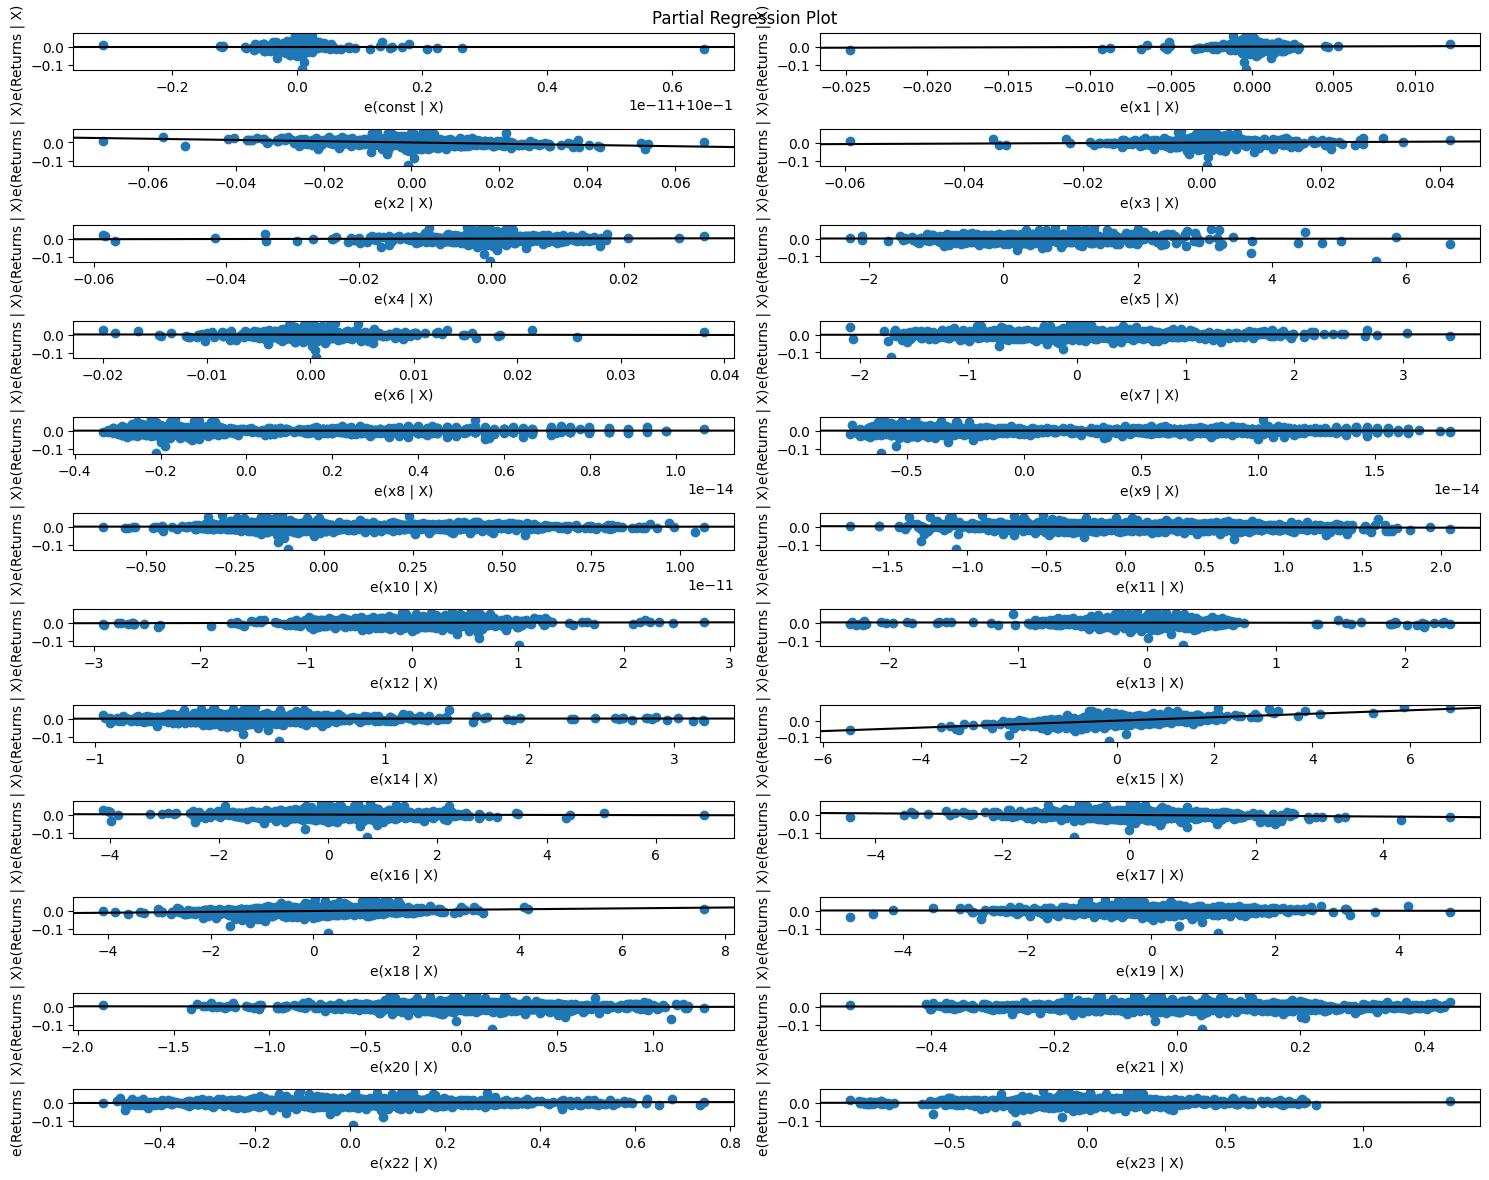

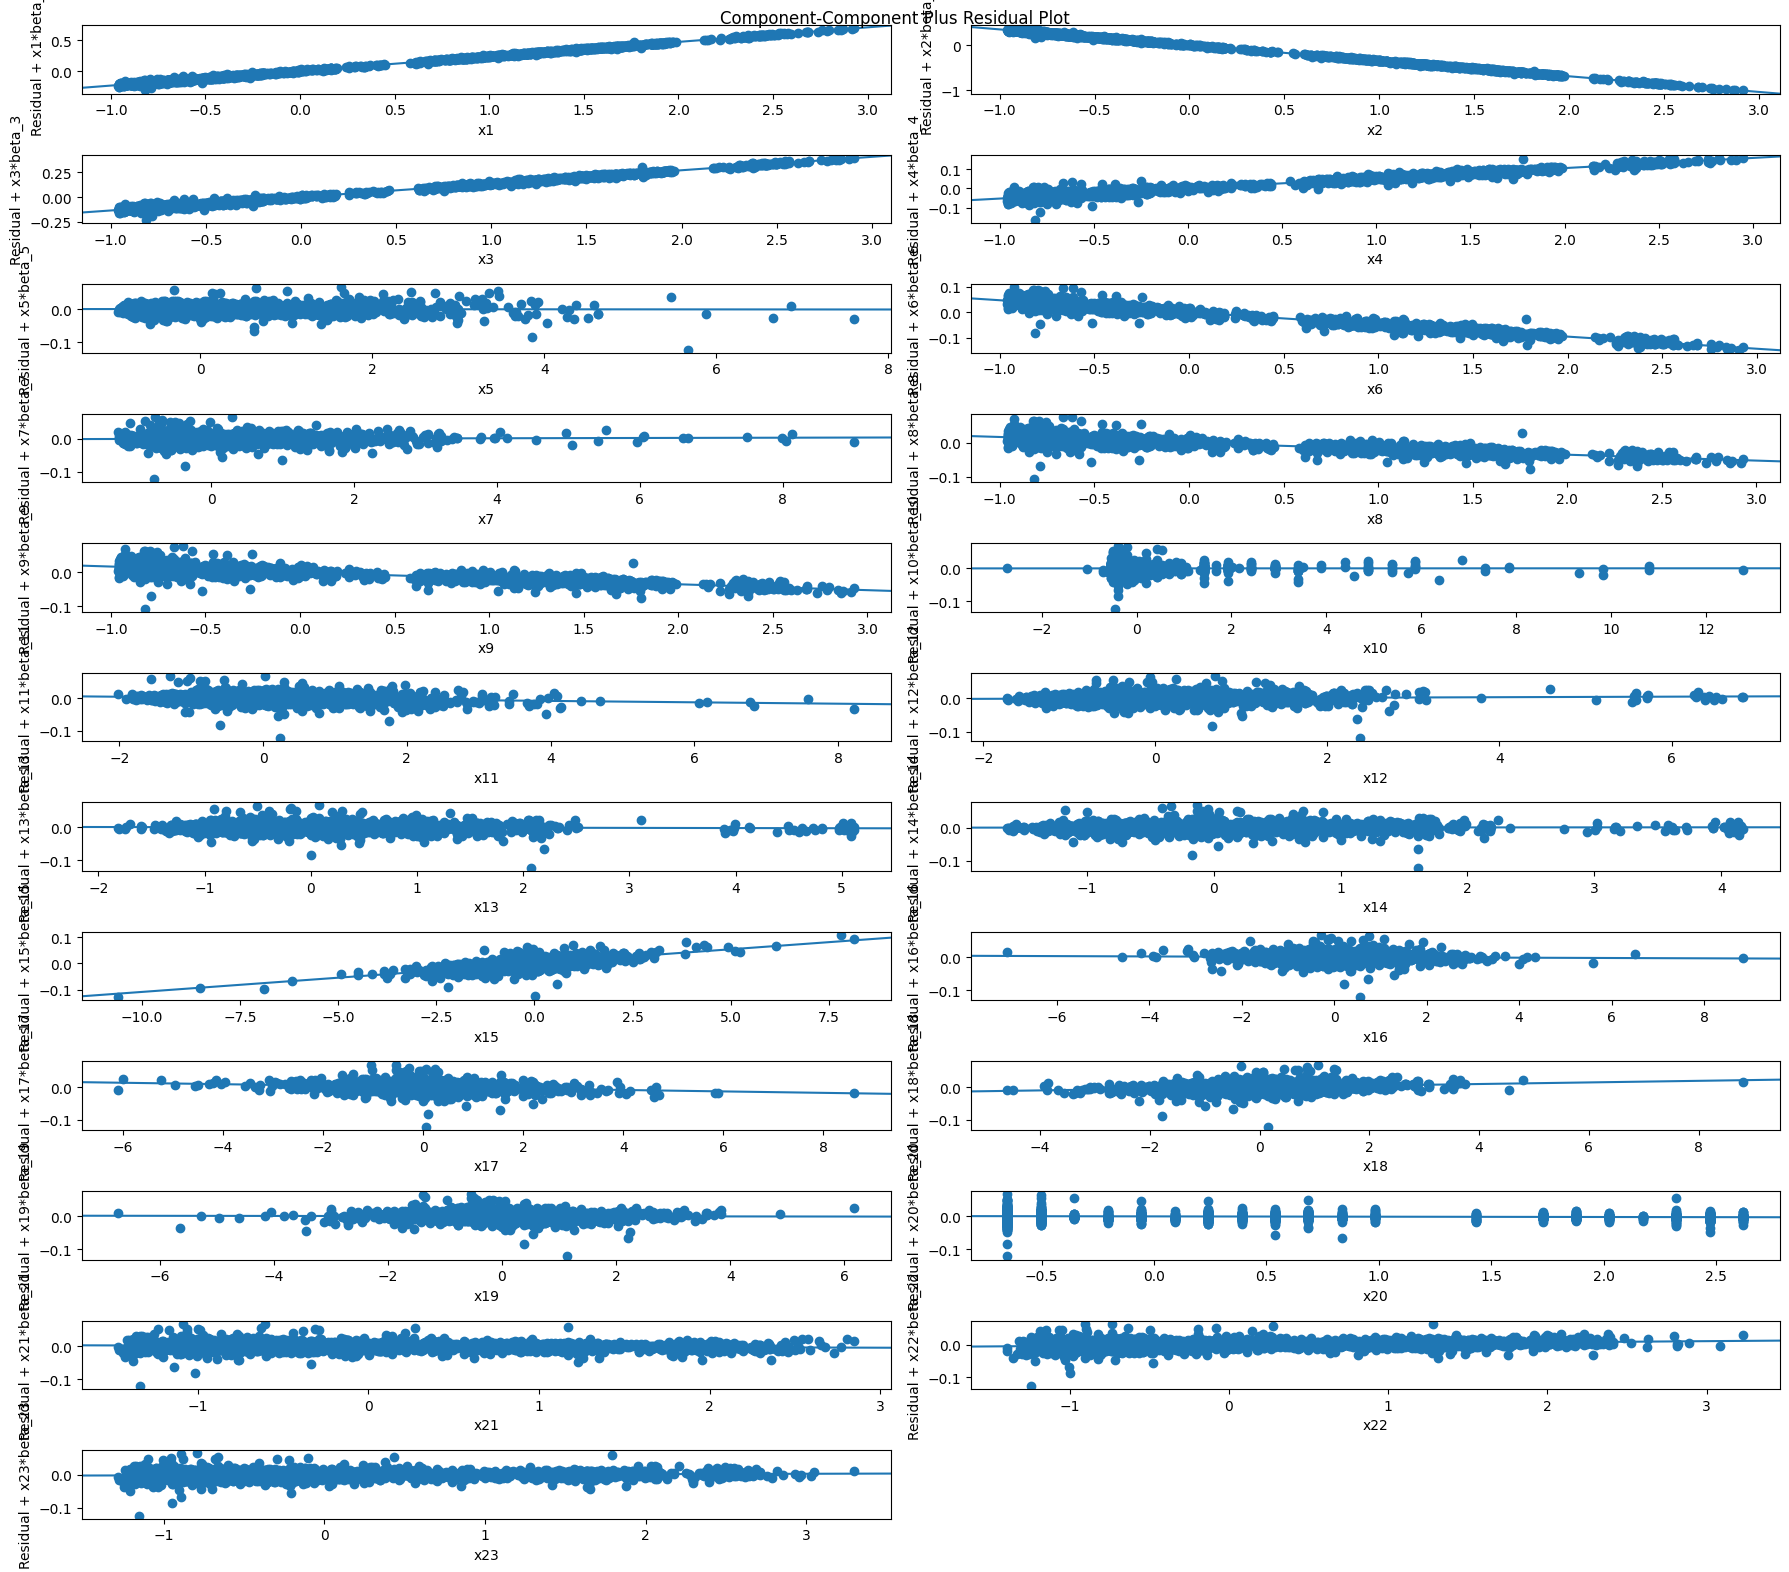

In [ ]:
# To assess linearity, it is useful to examine each predictor individually, such as through residuals vs predicted values plots, to identify potential non-linear relationships between the independent and dependent variables.

# Partial Regression Plots
# Each subplot visualizes the linear relationship between the dependent variable and one independent variable, controlling for the effect of all other variables.
fig = plt.figure(figsize=(15, 12))  # Increase size (width, height)
sm.graphics.plot_partregress_grid(result, fig=fig)

plt.tight_layout()
plt.show()

# How to read:
# - A linear pattern supports the linearity assumption.
# - Deviations (e.g., curves or fan shapes) may indicate that the relationship is not linear.
# These plots are useful for detecting non-linear trends that could violate OLS assumptions.

# we can also use the Component-Component Plus Residual (CCPR) Plots
# Each subplot shows the relationship between the response variable and a single predictor, adjusting for the presence of all other predictors in the model.
fig = plt.figure(figsize=(18, 16))  # Wider and taller figure
sm.graphics.plot_ccpr_grid(result, fig=fig)
plt.tight_layout()
plt.show()

# How to read:
# - A roughly straight line suggests a linear relationship (supporting the linearity assumption).
# - Curved patterns or scattered residuals may indicate non-linearity or lack of predictive power.
# - Outliers or leverage points can also be visually detected.

# These plots help confirm whether each predictor contributes linearly to the model or if transformation might be needed.


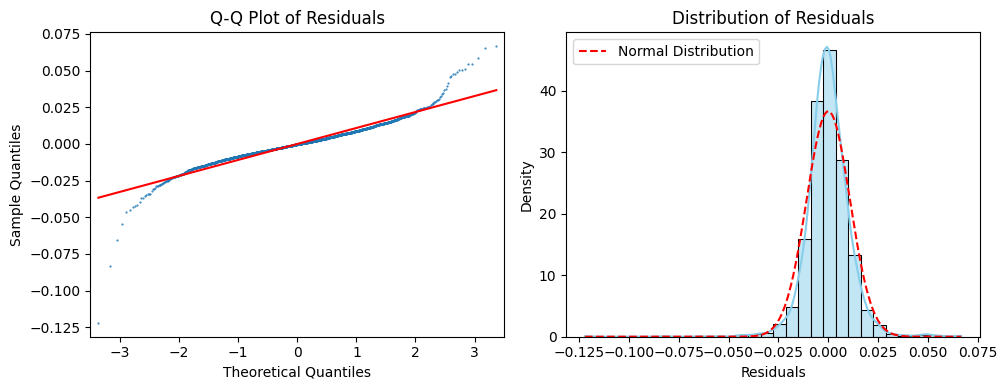

In [ ]:
# Fit the LinearRegression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict target variable
y_pred = model.predict(X_val_scaled)

# Residuals from your statsmodels OLS result
residuals = result.resid

# Prepare figure
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Q-Q Plot ---
sm.qqplot(residuals, line='s', ax=axes[0], marker='o', markersize=0.5)
axes[0].set_title("Q-Q Plot of Residuals")

# --- Distribution Plot with KDE and Normal Curve ---
sns.histplot(residuals, kde=True, bins=30, stat='density', ax=axes[1], color='skyblue', edgecolor='black')

# Overlay normal distribution curve
x_vals = np.linspace(residuals.min(), residuals.max(), 200)
mean = np.mean(residuals)
std = np.std(residuals)
axes[1].plot(x_vals, norm.pdf(x_vals, mean, std), 'r--', label='Normal Distribution')

axes[1].set_title("Distribution of Residuals")
axes[1].set_xlabel("Residuals")
axes[1].set_ylabel("Density")
axes[1].legend()

plt.tight_layout()
plt.show()


**Q-Q Plot of Residuals**
- How to Read: Points should lie along the red 45° line if residuals are normally distributed.
- Result: Deviations in the tails suggest slight departure from normality, indicating possible skewness or heavy tails.

**Distribution of Residuals**
- How to Read: The histogram should resemble a bell-shaped curve for normality.
- Result: The histogram is roughly symmetric but more peaked with fatter tails than the overlaid normal curve → this confirms a leptokurtic distribution (non-normal, sharp peak + heavy tails).


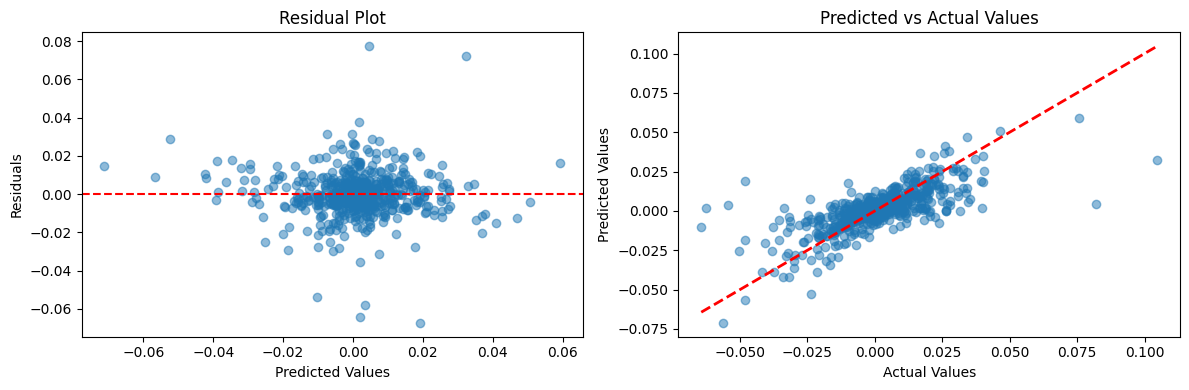

In [ ]:
# The 'LinearRegression' model is initialized and fitted to the training data.
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# The model is used to predict the target variable for the test set.
y_pred = model.predict(X_val_scaled)

# Calculate residuals
residuals = y_val - y_pred

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- Residual Plot ---
axes[0].scatter(y_pred, residuals, alpha=0.5)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot')

# --- Predicted vs Actual Plot ---
axes[1].scatter(y_val, y_pred, alpha=0.5)
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title('Predicted vs Actual Values')

# Adjust layout and show
plt.tight_layout()
plt.show()


**Residual Plot**

- How to Read: Residuals should be randomly scattered around zero to confirm linearity and constant variance.
- Result: Residuals are roughly centered, supporting linearity, but slight spread may suggest mild heteroscedasticity.

**Predicted vs Actual**
- How to Read: Points close to the red dashed line indicate accurate predictions.
- Result: The model tracks the actual values reasonably well, but prediction errors increase for extreme values (outliers).

**Zero Conditional Mean assumption:**
- The residual plot shows points roughly scattered around zero, suggesting that the assumption of a zero conditional mean is reasonably satisfied.




-----
## Baseline Prediction ##
In this section, we establish a baseline on the validation set. The objective is to benchmark the model’s predictive performance prior to addressing assumption violations, providing a reference point to evaluate improvements achieved through subsequent model refinement.



In [ ]:
# The 'LinearRegression' model is initialized and fitted to the training data.
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# The model is used to predict the target variable for the test set.
y_pred = model.predict(X_val_scaled)

# --- Directional Accuracy ---
def directional_accuracy(y_true, y_pred):
    # Shift actual and predicted values to compute the direction
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the direction of actual and predicted change
    actual_direction = np.sign(y_true[1:] - y_true[:-1])
    predicted_direction = np.sign(y_pred[1:] - y_pred[:-1])

    # Compute directional accuracy
    return np.mean(actual_direction == predicted_direction)

# Evaluation metrics
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
mad = median_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
direction_acc = directional_accuracy(y_val, y_pred)

# Print evaluation results
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Median Absolute Deviation (MAD): {mad:.6f}")
print(f"R-squared: {r2:.6f}")
print(f"Directional Accuracy: {direction_acc:.6f}")

Mean Squared Error (MSE): 0.000145
Root Mean Squared Error (RMSE): 0.012032
Mean Absolute Error (MAE): 0.008028
Median Absolute Deviation (MAD): 0.005669
R-squared: 0.532486
Directional Accuracy: 0.768142


-----
## Handling Multicollinearity ##

### Correlation matrix ###

In [ ]:
print(X_train.shape)
print(X_train_scaled.shape)
print(y_train.shape)

(2641, 23)
(2641, 23)
(2641,)


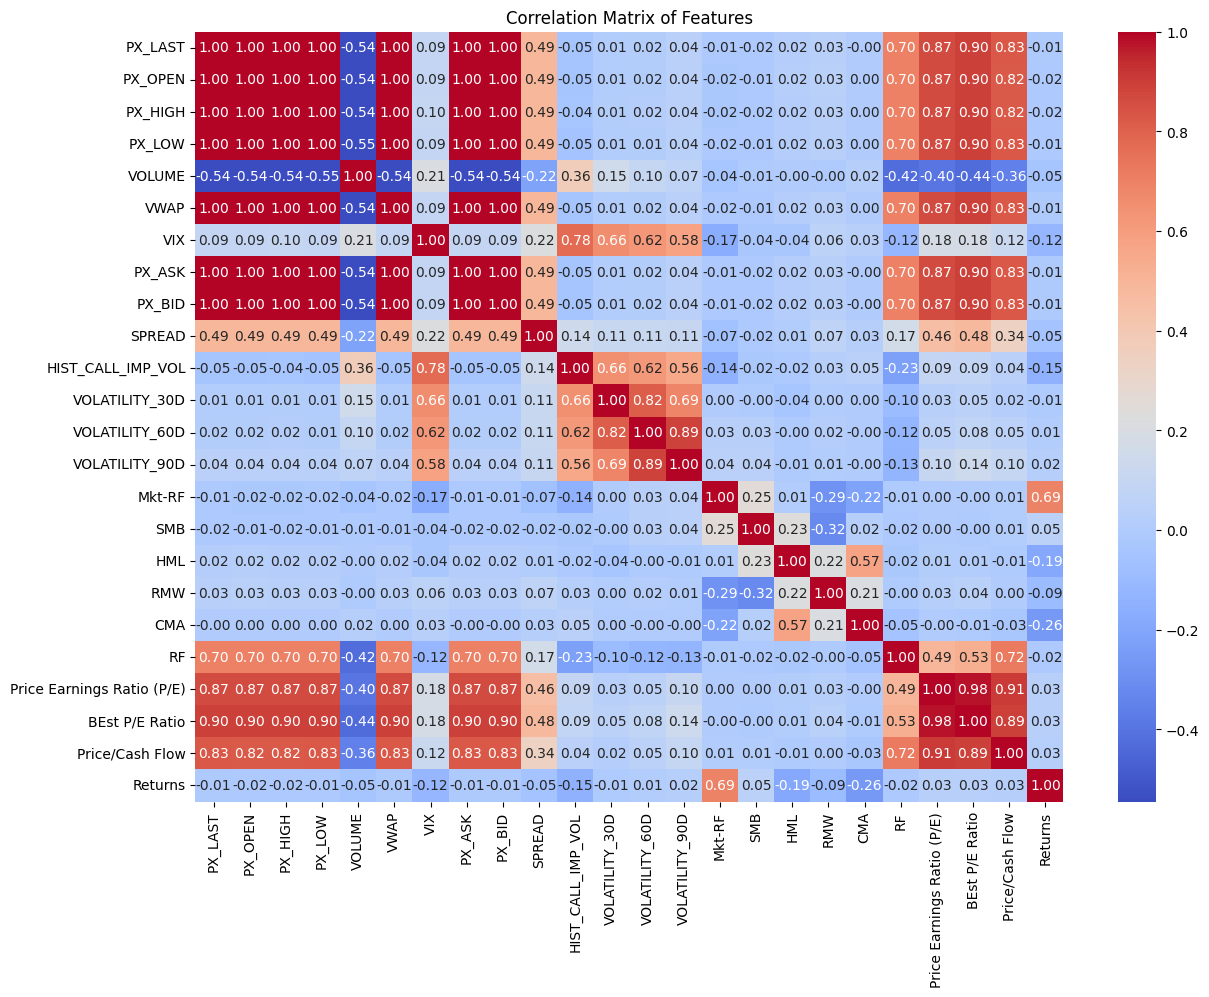

In [ ]:
# Combine features and target into one DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Calculate the correlation matrix
corr_matrix = train_data.corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [ ]:
# Unstack the correlation matrix
stacked_corr = corr_matrix.unstack()

# Remove self-correlations
filtered_corr = stacked_corr[stacked_corr != 1]

# Keep only pairs with correlation above 0.9
high_corr = filtered_corr[filtered_corr > 0.9]

# Drop duplicate pairs (e.g., (A, B) and (B, A))
high_corr = high_corr[~high_corr.index.duplicated(keep='first')]

# Display the result
print("Highly Correlated Feature Pairs (correlation > 0.9):")
print(high_corr)


Highly Correlated Feature Pairs (correlation > 0.9):
PX_LAST                     PX_OPEN                       0.999815
                            PX_HIGH                       0.999905
                            PX_LOW                        0.999917
                            VWAP                          0.999966
                            PX_ASK                        1.000000
                            PX_BID                        1.000000
PX_OPEN                     PX_LAST                       0.999815
                            PX_HIGH                       0.999920
                            PX_LOW                        0.999907
                            VWAP                          0.999905
                            PX_ASK                        0.999815
                            PX_BID                        0.999814
PX_HIGH                     PX_LAST                       0.999905
                            PX_OPEN                       0.999920
         

In [ ]:
def get_highly_correlated_features(df, threshold=0.9):
    # Compute absolute correlation matrix
    corr_matrix = df.corr().abs()

    # Keep upper triangle of the matrix (excluding self-correlations)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify features to consider for removal
    features_to_remove = set()
    for column in upper.columns:
        high_corr_features = upper.index[upper[column] > threshold].tolist()
        if high_corr_features:
            features_to_remove.add(column)

    return sorted(features_to_remove)

# Example usage:
features_to_remove = get_highly_correlated_features(X_train, threshold=0.9)

print("Features to consider removing due to high correlation:")
print(features_to_remove)


Features to consider removing due to high correlation:
['BEst P/E Ratio', 'PX_ASK', 'PX_BID', 'PX_HIGH', 'PX_LOW', 'PX_OPEN', 'Price/Cash Flow', 'VWAP']


To address multicollinearity, features with a correlation coefficient greater than 0.9 were identified. These variables exhibit strong linear relationships with others and may inflate the variance of regression coefficients, thereby distorting model estimates.

Based on the correlation analysis, the following features were removed:

- `BEst P/E Ratio`
- `PX_ASK`  
- `PX_BID`  
- `PX_HIGH`
- `PX_LOW`
- `PX_OPEN`
- `Price/Cash Flow`  
- `VWAP`

Removing these variables helps to reduce redundancy and improve the stability and interpretability of the regression model.


In [ ]:
for col in X_train.columns:
    print(f"'{col}'")

'PX_LAST'
'PX_OPEN'
'PX_HIGH'
'PX_LOW'
'VOLUME'
'VWAP'
'VIX'
'PX_ASK'
'PX_BID'
'SPREAD'
'HIST_CALL_IMP_VOL'
'VOLATILITY_30D'
'VOLATILITY_60D'
'VOLATILITY_90D'
'Mkt-RF'
'SMB'
'HML'
'RMW'
'CMA'
'RF'
'Price Earnings Ratio (P/E)'
'BEst P/E Ratio'
'Price/Cash Flow'


In [ ]:
features_to_remove = [
    "BEst P/E Ratio",
    "PX_ASK",
    "PX_BID",
    "PX_HIGH",
    "PX_LOW",
    "PX_OPEN",
    "Price/Cash Flow",
    "VWAP"

]

X_train = X_train.drop(columns=features_to_remove)

In [ ]:
print("X_train shape:", X_train.shape)

X_train shape: (2641, 15)


### Variance Inflation Factor (VIF) ###

In [ ]:
# As a potential next step, one could test different feature combinations before removing all the indicated variables,
# in order to evaluate their individual and joint impact on model performance.

Features with VIF above threshold:
                       Feature        VIF
0                      PX_LAST  15.993372
1                       VOLUME   3.712433
2                          VIX  22.920403
3                       SPREAD   1.919127
4            HIST_CALL_IMP_VOL  44.349404
5               VOLATILITY_30D  27.025150
6               VOLATILITY_60D  78.737359
7               VOLATILITY_90D  59.388803
8                       Mkt-RF   1.290801
9                          SMB   1.295094
10                         HML   1.749308
11                         RMW   1.316268
12                         CMA   1.620041
13                          RF   3.235705
14  Price Earnings Ratio (P/E)  29.644609


<Figure size 1200x600 with 0 Axes>

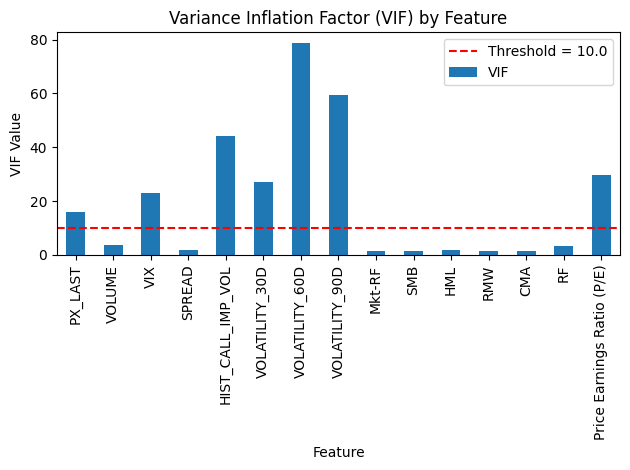


Features to consider removing (VIF > 10.0):
['PX_LAST', 'VIX', 'HIST_CALL_IMP_VOL', 'VOLATILITY_30D', 'VOLATILITY_60D', 'VOLATILITY_90D', 'Price Earnings Ratio (P/E)']


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Funzione per calcolare VIF e restituire le feature con VIF alto
def get_high_vif_features(X, threshold=10.0):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Filtra le feature con VIF > threshold
    features_to_remove = vif_data[vif_data['VIF'] > threshold]['Feature'].tolist()

    # Stampa i risultati
    print("Features with VIF above threshold:")
    print(vif_data)


    # Plot VIF
    plt.figure(figsize=(12, 6))
    vif_data.plot(kind='bar', x='Feature', y='VIF', legend=False)
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')
    plt.title('Variance Inflation Factor (VIF) by Feature')
    plt.ylabel('VIF Value')
    plt.tight_layout()
    plt.legend()
    plt.show()

    print("\nFeatures to consider removing (VIF > {}):".format(threshold))
    print(features_to_remove)

    return features_to_remove

# Esempio d’uso:
features_to_remove = get_high_vif_features(X_train, threshold=10.0)


In [ ]:
features_to_remove = [
    "PX_LAST",
    "VIX",
    "HIST_CALL_IMP_VOL",
    "VOLATILITY_30D",
    "VOLATILITY_60D",
    "VOLATILITY_90D",
    "Price Earnings Ratio (P/E)"
]

X_train = X_train.drop(columns=features_to_remove)

In [ ]:
X_train.head()

,VOLUME,SPREAD,Mkt-RF,SMB,HML,RMW,CMA,RF
1664,74641736,0.002,-0.06,0.14,-0.17,-0.14,-0.28,0.001
594,399545328,0.005,-0.29,0.12,-1.07,0.00,-0.06,0.000
742,625258508,0.006,-0.58,0.09,0.07,0.10,0.12,0.001
3575,55215244,0.020,0.54,0.45,-0.24,0.49,0.08,0.021
193,658403256,0.006,0.74,0.86,-0.20,-0.30,0.40,0.001


-----
## Ordinary Least Squares (OLS) — After Removing Features Violating Assumptions  ##

In [ ]:
# Check shapes of the datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2641, 8)
y_train shape: (2641,)
X_val shape: (566, 23)
y_val shape: (566,)
X_test shape: (567, 23)
y_test shape: (567,)


In [ ]:
features_to_remove = [
    "PX_OPEN",
    "PX_HIGH",
    "PX_LOW",
    "PX_LAST",
    "VIX",
    "HIST_CALL_IMP_VOL",
    "VOLATILITY_30D",
    "VOLATILITY_60D",
    "VOLATILITY_90D",
    "Price Earnings Ratio (P/E)",
    "VWAP",
    "PX_ASK",
    "PX_BID",
    "BEst P/E Ratio",
    "Price/Cash Flow"
]

X_val = X_val.drop(columns=features_to_remove)
X_test = X_test.drop(columns=features_to_remove)

In [ ]:
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_val shape: (566, 8)
X_test shape: (567, 8)


In [ ]:
# --- Apply Scaling ---
scaler_X = StandardScaler()

# Fit only on training data
X_train_scaled = scaler_X.fit_transform(X_train)

# Transform validation and test sets
X_val_scaled = scaler_X.transform(X_val)

In [ ]:
# Define the modell
X_train_constant = sm.add_constant(X_train_scaled) # Including a constant (intercept) in a linear regression model is crucial unless there is a strong theoretical reason to exclude it. Excluding the intercept forces the line through the origin, which can lead to biased coefficients, distorted model fit, and invalid.
model = sm.OLS(y_train, X_train_constant)

# Fit the model
result = model.fit()

# Print the model summary
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     396.6
Date:                Tue, 19 Aug 2025   Prob (F-statistic):               0.00
Time:                        20:15:32   Log-Likelihood:                 7960.8
No. Observations:                2641   AIC:                        -1.590e+04
Df Residuals:                    2632   BIC:                        -1.585e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      4.608      0.0

In [ ]:
# Print the columns of X_train to see which feature corresponds to each x in the OLS summary
print("Features corresponding to OLS terms (x1, x2, ...):")
for i, col in enumerate(X_train.columns):
    print(f"x{i+1}: {col}")

Features corresponding to OLS terms (x1, x2, ...):
x1: VOLUME
x2: SPREAD
x3: Mkt-RF
x4: SMB
x5: HML
x6: RMW
x7: CMA
x8: RF


In [ ]:
# Breusch–Pagan Test
bp_test = het_breuschpagan(result.resid, result.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value']
print(dict(zip(labels, bp_test)))


{'Lagrange multiplier statistic': np.float64(255.21199560094078), 'p-value': np.float64(1.3524801259237297e-50)}


### Assumptions Check – OLS Regression (Updated)

1. Linearity
   Indirectly supported. F-statistic = 396.6 (p = 0.000) → the model explains a significant share of variance.

2. No Perfect Multicollinearity
   Condition Number = 2.31 → low; no evidence of severe multicollinearity.

3. Zero Conditional Mean  
   Cannot be directly tested; we will evaluate it via residual plots and Q–Q plots. If correctly specified, residuals should be randomly centered around 0 with no patterns.

4. Homoscedasticity  
   Residual variance was formally tested using the Breusch–Pagan test: LM = 255.21, p < 0.001, providing strong evidence of heteroskedasticity.  
   Additionally, the Jarque–Bera = 6402.435 (p = 0.000) and Kurtosis = 10.619 indicate non-normal residuals, which may further be associated with heteroskedasticity.

5. No Autocorrelation  
   Durbin–Watson = 1.963 → close to 2, suggesting no significant autocorrelation of residuals.

6. Normality of Residuals  
   - Omnibus = 414.788, p = 0.000 → not normal.  
   - Jarque–Bera = 6402.435, p = 0.000 → strong rejection of normality.  
   - Skewness = −0.186 (slight left skew).  
   - Kurtosis = 10.619 → leptokurtic (heavy tails).

7. Other Observations  
   Significant predictors:  
   - x3 (PX_HIGH): p = 0.000  
   - x4 (PX_LOW): p = 0.007  
   - x5 (VOLUME): p = 0.000  
   - x6 (VWAP): p = 0.000  
   These variables contribute meaningfully to explaining Returns


We re-estimate the regression using heteroskedasticity-robust standard errors (HC3) and Weighted Least Squares (WLS) to account for potential heteroskedasticity and check the robustness of our results.

In [ ]:
robust_result = result.get_robustcov_results(cov_type='HC3')
print(robust_result.summary())

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     327.6
Date:                Tue, 19 Aug 2025   Prob (F-statistic):               0.00
Time:                        20:26:28   Log-Likelihood:                 7960.8
No. Observations:                2641   AIC:                        -1.590e+04
Df Residuals:                    2632   BIC:                        -1.585e+04
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      4.593      0.0

In [ ]:
wls_model = sm.WLS(y_train, X_train_constant, weights=1/np.var(result.resid))
wls_result = wls_model.fit()
print(wls_result.summary())

                            WLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.547
Model:                            WLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     396.6
Date:                Tue, 19 Aug 2025   Prob (F-statistic):               0.00
Time:                        20:24:18   Log-Likelihood:                 7960.8
No. Observations:                2641   AIC:                        -1.590e+04
Df Residuals:                    2632   BIC:                        -1.585e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      4.608      0.0

We re-estimated the model using heteroskedasticity-robust standard errors (HC3) and Weighted Least Squares (WLS) to address the heteroskedasticity detected in the residuals. However, the results show that while coefficients remain stable, the problem of non-constant variance persists, confirming that heteroskedasticity is an intrinsic feature of the data rather than a specification issue.

## Prediction on Validation Set ##

In [56]:
# The 'LinearRegression' model is initialized and fitted to the training data.
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# The model is used to predict the target variable for the test set.
y_pred = model.predict(X_val_scaled)

# Evaluation metrics
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
mad = median_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
direction_acc = directional_accuracy(y_val, y_pred)

# Print evaluation results
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Median Absolute Deviation (MAD): {mad:.6f}")
print(f"R-squared: {r2:.6f}")
print(f"Directional Accuracy: {direction_acc:.6f}")

Mean Squared Error (MSE): 0.000174
Root Mean Squared Error (RMSE): 0.013177
Mean Absolute Error (MAE): 0.008999
Median Absolute Deviation (MAD): 0.006193
R-squared: 0.439273
Directional Accuracy: 0.738053


-----
## Ordinary Least Squares (OLS) — Evaluation on Out-of-Sample Data  ##

In [57]:
# Concatenate X_train and X_val
X_train_new = np.concatenate((X_train, X_val), axis=0)

# If you also want to combine the corresponding y values:
y_train_new = np.concatenate((y_train, y_val), axis=0)

In [58]:
print("X_train_new shape:", X_train_new.shape)
print("y_train_new shape:", y_train_new.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train_new shape: (3207, 8)
y_train_new shape: (3207,)
X_test shape: (567, 8)
y_test shape: (567,)


In [59]:
# --- Apply Scaling ---
scaler_X = StandardScaler()

# Fit only on training data
X_train_new_scaled = scaler_X.fit_transform(X_train_new)

# Transform validation and test sets
X_test_scaled = scaler_X.transform(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [60]:
# Define the modell
X_train_new_constant = sm.add_constant(X_train_new_scaled) # Including a constant (intercept) in a linear regression model is crucial unless there is a strong theoretical reason to exclude it. Excluding the intercept forces the line through the origin, which can lead to biased coefficients, distorted model fit, and invalid.
model = sm.OLS(y_train_new, X_train_new_constant)

# Fit the model
result = model.fit()

# Print the model summary
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     446.9
Date:                Tue, 19 Aug 2025   Prob (F-statistic):               0.00
Time:                        20:32:37   Log-Likelihood:                 9603.1
No. Observations:                3207   AIC:                        -1.919e+04
Df Residuals:                    3198   BIC:                        -1.913e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      5.151      0.0

## Prediction on Out-of-Sample Data ##

In [62]:
# The 'LinearRegression' model is initialized and fitted to the training data.
model = LinearRegression()
model.fit(X_train_new_scaled, y_train_new)

# The model is used to predict the target variable for the test set.
y_pred = model.predict(X_test_scaled)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mad = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
direction_acc = directional_accuracy(y_test, y_pred)

# Print evaluation results
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Median Absolute Deviation (MAD): {mad:.6f}")
print(f"R-squared: {r2:.6f}")
print(f"Directional Accuracy: {direction_acc:.6f}")

Mean Squared Error (MSE): 0.000139
Root Mean Squared Error (RMSE): 0.011780
Mean Absolute Error (MAE): 0.008329
Median Absolute Deviation (MAD): 0.006049
R-squared: 0.527068
Directional Accuracy: 0.734982


*Note: It should be emphasized that some of the classical regression assumptions are not fully satisfied, particularly the assumption of homoskedasticity. As a result, the reported findings must be interpreted with caution.*